# Lab - Membership Inference

## Install dependencies

In [ ]:
%pip install torch torchvision tqdm scikit-learn matplotlib

## Prepare the dataset

This sets up three slices of CIFAR-10:

- Train: the secret dataset that's used to train the target model (not available to the attacker)
- Hold-out: a dataset that's available to the attacker
- Test: a dataset used for evaluation of the membership inference attack (not available to the attacker)

In [2]:
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import random_split, ConcatDataset
from torchvision.transforms import ToTensor
from torchvision.datasets import CIFAR10
from tqdm.auto import tqdm
import matplotlib.pyplot as plt

In [3]:
cifar10_train = CIFAR10(root='./cifar10', train=True, download=True, transform=ToTensor())
cifar10_test = CIFAR10(root='./cifar10', train=False, download=True, transform=ToTensor())
cifar10_all = ConcatDataset([cifar10_train, cifar10_test])

train_ds, test_ds, holdout_ds = \
    random_split(cifar10_all, [.25, .25, .5], generator=torch.Generator().manual_seed(1337))

Files already downloaded and verified
Files already downloaded and verified


In [4]:
from torch.utils.data.dataset import Dataset

class AppendDataset(Dataset):
    '''
    Appends a constant label to all points in a dataset.
    '''
    def __init__(self, ds, y):
        self._ds = ds
        self._y = y
    
    def __getitem__(self, idx):
        x = self._ds[idx]
        return x, self._y
    
    def __len__(self):
        return len(self._ds)

In [5]:
mi_test_ds = ConcatDataset([AppendDataset(train_ds, True), AppendDataset(test_ds, False)])
mi_test_ds_labels = np.array([i[1] for i in mi_test_ds])

## Train the target model

This is included in the solution notebook just to reveal how the target trained their model. It is not available to the attacker.

In [6]:
from target_model import get_model

model = get_model()

model = model.cuda()

In [7]:
BATCH_SIZE = 50
EPOCHS = 100

train_loader = torch.utils.data.DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True, pin_memory=True)
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters())

model.train()

losses = []

for epoch in tqdm(range(EPOCHS), postfix='Epoch', leave=False):
    count = 0
    loss_sum = 0
    for data, targets in tqdm(train_loader, leave=False, postfix='Train'):
        optimizer.zero_grad()
        data = data.cuda()
        targets = targets.cuda()
        logits = model(data)
        loss = criterion(logits, targets)
        loss.backward()
        optimizer.step()
        
        loss_sum += loss.cpu().detach().numpy()
        count += 1

    losses.append(loss_sum / count)
    if len(losses) > 2 and losses[-1] > losses[-2] and losses[-2] > losses[-3]:
        break

  0%|          | 0/100 [00:00<?, ?it/s, Epoch]

  0%|          | 0/300 [00:00<?, ?it/s, Train]

  0%|          | 0/300 [00:00<?, ?it/s, Train]

  0%|          | 0/300 [00:00<?, ?it/s, Train]

  0%|          | 0/300 [00:00<?, ?it/s, Train]

  0%|          | 0/300 [00:00<?, ?it/s, Train]

  0%|          | 0/300 [00:00<?, ?it/s, Train]

  0%|          | 0/300 [00:00<?, ?it/s, Train]

  0%|          | 0/300 [00:00<?, ?it/s, Train]

  0%|          | 0/300 [00:00<?, ?it/s, Train]

  0%|          | 0/300 [00:00<?, ?it/s, Train]

  0%|          | 0/300 [00:00<?, ?it/s, Train]

  0%|          | 0/300 [00:00<?, ?it/s, Train]

  0%|          | 0/300 [00:00<?, ?it/s, Train]

  0%|          | 0/300 [00:00<?, ?it/s, Train]

  0%|          | 0/300 [00:00<?, ?it/s, Train]

  0%|          | 0/300 [00:00<?, ?it/s, Train]

  0%|          | 0/300 [00:00<?, ?it/s, Train]

  0%|          | 0/300 [00:00<?, ?it/s, Train]

  0%|          | 0/300 [00:00<?, ?it/s, Train]

  0%|          | 0/300 [00:00<?, ?it/s, Train]

  0%|          | 0/300 [00:00<?, ?it/s, Train]

  0%|          | 0/300 [00:00<?, ?it/s, Train]

  0%|          | 0/300 [00:00<?, ?it/s, Train]

  0%|          | 0/300 [00:00<?, ?it/s, Train]

  0%|          | 0/300 [00:00<?, ?it/s, Train]

  0%|          | 0/300 [00:00<?, ?it/s, Train]

  0%|          | 0/300 [00:00<?, ?it/s, Train]

  0%|          | 0/300 [00:00<?, ?it/s, Train]

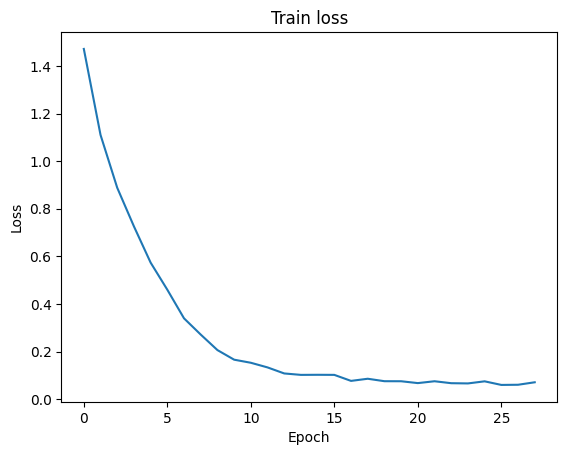

In [8]:
plt.plot(losses)
plt.title('Train loss')
plt.xlabel('Epoch')
_ = plt.ylabel('Loss')

In [9]:
test_loader = torch.utils.data.DataLoader(test_ds, batch_size=BATCH_SIZE, shuffle=True, pin_memory=True)

correct = 0

model.eval()

with torch.no_grad():
    for data, targets in tqdm(test_loader, leave=False, postfix='Test'):
        data = data.cuda()
        targets = targets.cuda()
        logits = model(data)
        probs = torch.softmax(logits, dim=1).detach().cpu().numpy()
        preds = np.argmax(probs, axis=1)
        correct += np.sum(preds == targets.cpu().numpy())
acc = correct * 100 / len(test_ds)
print(f'Accuracy: {acc:.2f}%')

  0%|          | 0/300 [00:00<?, ?it/s, Test]

Accuracy: 65.89%


In [10]:
torch.save(model.state_dict(), 'target_model.pt')

## Load target model

In [11]:
from target_model import get_model
# note: the target_model.py file
# is part of the lab infrastructure; the attacker does not get to see
# the code inside target_model, only make black-box inferences
# using the target model

target_model = get_model()
target_model.load_state_dict(torch.load('target_model.pt'))
target_model.eval()

if torch.cuda.is_available():
    target_model = target_model.cuda()

## Tools to evaluate your attack

In [12]:
from sklearn import metrics
from matplotlib import pyplot as plt

def run_attack(attack, batch_size=50):
    loader = torch.utils.data.DataLoader(mi_test_ds, batch_size=batch_size, shuffle=False, pin_memory=True)
    all_preds = []
    for (images, classes), labels in loader:
        with torch.no_grad():
            model_input = images
            if torch.cuda.is_available():
                model_input = images.cuda()
            target_model_outputs = nn.functional.softmax(target_model(model_input))
        preds = attack(images, classes, target_model_outputs)
        if hasattr(preds, 'cpu'):
            preds = preds.cpu().detach().numpy()
        labels = labels.cpu().detach().numpy()
        all_preds.append(preds)
    all_preds = np.concatenate(all_preds)
    
    return all_preds

def plot_roc(*scores_and_names):
    '''
    Plots an ROC curve and computes AUC, given a list of scores and method names.
    
    Call this function like plot_roc(scores1, 'name of attack 1', scores2, 'name of attack 2', ...)
    to compare different attacks.
    '''
    fpr = []
    tpr = []
    for score, name in zip(scores_and_names[::2], scores_and_names[1::2]):
        fpr, tpr, thresholds = metrics.roc_curve(mi_test_ds_labels, score)
        auc = metrics.roc_auc_score(mi_test_ds_labels, score)
        plt.plot(fpr, tpr, label=f'{name} (AUC = {auc:.2f})')
    plt.legend(loc=0)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')

def compute_stats(*preds_and_names):
    fpr = []
    tpr = []
    for pred, name in zip(preds_and_names[::2], preds_and_names[1::2]):
        precision = metrics.precision_score(mi_test_ds_labels, pred)
        recall = metrics.recall_score(mi_test_ds_labels, pred)
        f1 = metrics.f1_score(mi_test_ds_labels, pred)
        print(name)
        print(f'  Precision: {precision:.4f}')
        print(f'     Recall: {recall:.4f}')
        print(f'   F1 Score: {f1:.4f}')
        print()

## Membership inference attacks

A membership inference attack is implemented as a function that takes in a tensor of data points (floats, `[N, C, H, W]`), class labels (integer-encoded, `[N]`), and model outputs from the black-box target model (floats, `[N, 10]`), and predicts whether or not they were used in the training set of the target model. The attack can either return an array of booleans or an array of scores. If it returns scores, the lab infrastructure can compute ROC and AUC for you.

A higher score means that the data point is more likely to belong to the training set.

Here, we implement a couple silly attacks, just to show you how the pieces of the lab infrastructure fit together.

In [13]:
def membership_inference_attack_random_bool(x, y, probs):
    '''
    A silly "attack" that returns random results.
    '''
    return np.random.uniform(size=len(x)) > 0.5

def membership_inference_attack_random_score(x, y, probs):
    '''
    A silly "attack" that returns random scores.
    '''
    return np.random.uniform(size=len(x))

In [14]:
preds = run_attack(membership_inference_attack_random_bool)
compute_stats(preds, 'Random Prediction')
# note: it doesn't make sense to compute an ROC curve with predictions (only scores)

Random Prediction
  Precision: 0.4964
     Recall: 0.4999
   F1 Score: 0.4982



Random Score, Threshold = 0.55
  Precision: 0.5007
     Recall: 0.4495
   F1 Score: 0.4738



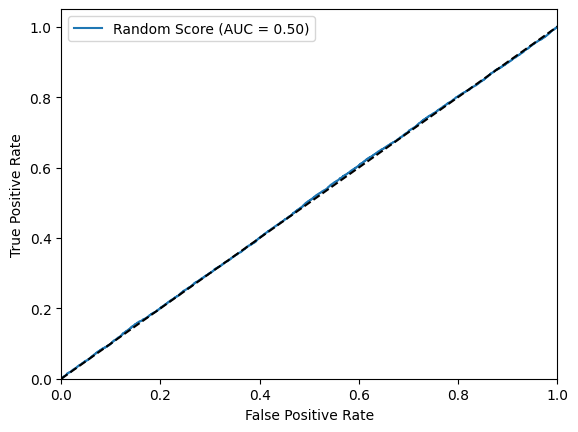

In [15]:
scores = run_attack(membership_inference_attack_random_score)
plot_roc(scores, 'Random Score')
compute_stats(scores > 0.55, 'Random Score, Threshold = 0.55')

# Exercise: implement membership inference attacks

Implement one (or multiple) of the membership inference attack algorithms described in lecture. We suggest that you start with some of the simpler ones (metric-based attacks), and then try a fancier attack (like the one using shadow models). If you use shadow models, you'll need to design your own neural network architectures (you don't know what the target model is using). You could try using pre-defined NN models, like `resnet18` from `torchvision.models`, or come up with your own.

To design/train your membership attack, you may use the labeled `holdout_ds` however you like. That dataset is fully available to the attacker. You should not use the ground-truth `mi_test_ds` that is used for evaluating your solution.

For methods that give scores, you can plot an ROC curve and look at the AUC. You can also think about how you'd choose a threshold (you don't have the ROC curve available to help you choose the threshold: the ROC curve is produced using ground truth data, which the attacker doesn't have access to).

### Prediction Correctness Based Membership Inference Attack

From [Yoem et al., 2017](https://arxiv.org/abs/1709.01604/)

In [16]:
def membership_inference_attack_prediction_correctness(x, y, probs):
    return y == np.argmax(probs.cpu(), axis=1)

In [17]:
preds = run_attack(membership_inference_attack_prediction_correctness)
compute_stats(preds, 'Prediction Correctness')

Prediction Correctness
  Precision: 0.5980
     Recall: 0.9803
   F1 Score: 0.7429



### Prediction Loss Based Membership Inference Attack

From [Yoem et al., 2017](https://arxiv.org/abs/1709.01604/)

In [18]:
def membership_inference_attack_prediction_loss(x, y, probs):
    # loss is log probability of target class
    # we skip the log because we just want scores, and log is monotonic
    probs = probs.cpu().numpy()
    y = y.numpy()
    return np.array([probs[i][y[i]] for i in range(len(probs))])

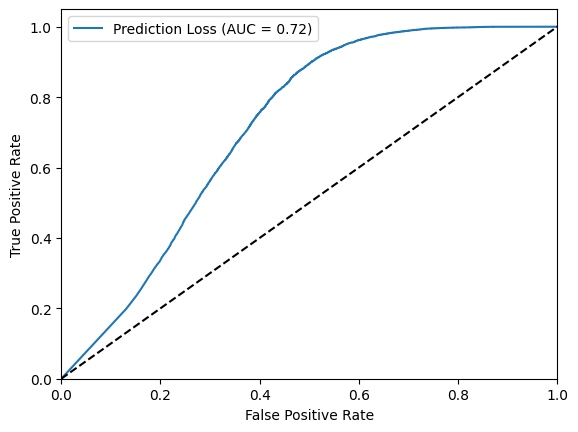

In [19]:
scores = run_attack(membership_inference_attack_prediction_loss)
plot_roc(scores, 'Prediction Loss')

### Prediction Confidence Based Membership Inference Attack

From [Salem et al., 2018](https://arxiv.org/abs/1806.01246).

In [20]:
def membership_inference_attack_prediction_confidence(x, y, probs):
    probs = probs.cpu().numpy()
    return np.array(np.max(probs, axis=1))

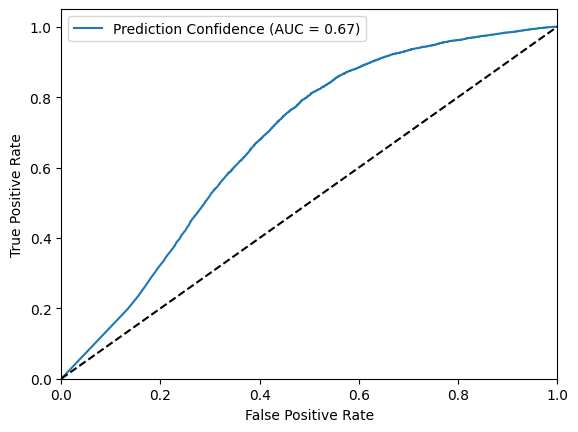

In [21]:
scores = run_attack(membership_inference_attack_prediction_confidence)
plot_roc(scores, 'Prediction Confidence')

### Prediction Entropy Based Membership Inference Attack

From [Salem et al., 2018](https://arxiv.org/abs/1806.01246).

In [22]:
from scipy.stats import entropy

def membership_inference_attack_prediction_entropy(x, y, probs):
    probs = probs.cpu().numpy()
    return np.array([-entropy(dist) for dist in probs])

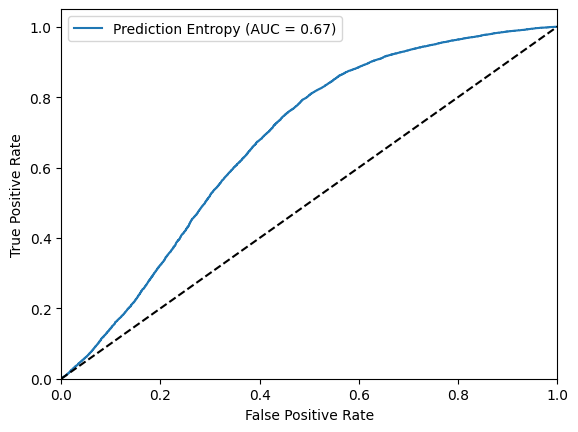

In [23]:
scores = run_attack(membership_inference_attack_prediction_entropy)
plot_roc(scores, 'Prediction Entropy')

### Shadow model based membership inference attack

From [Shokri et al., 2016](https://arxiv.org/abs/1610.05820).

#### Collect dataset used to train attack model.

We train a number of shadow models on subsets of the hold-out test dataset, to obtain a training dataset for our attack model. This dataset is of the form `(label, prediction, used_for_training)`, with outputs from shadow models on in-sample or out-of-sample data points (all chosen from the hold-out test dataset).

In [24]:
from torchvision.models import resnet18

def train_shadow_model(in_sample):
    model = resnet18()
    model.fc = nn.Linear(512, 10)
    model = get_model()

    if torch.cuda.is_available():
        model = model.cuda()

    BATCH_SIZE = 50
    MAX_EPOCHS = 20

    train_loader = torch.utils.data.DataLoader(in_sample, batch_size=BATCH_SIZE, shuffle=True, pin_memory=True)
    criterion = torch.nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters())

    model.train()

    losses = []

    for epoch in tqdm(range(MAX_EPOCHS), postfix='Epoch', leave=False):
        count = 0
        loss_sum = 0
        for data, targets in tqdm(train_loader, leave=False, postfix='Train'):
            optimizer.zero_grad()
            if torch.cuda.is_available():
                data = data.cuda()
                targets = targets.cuda()
            logits = model(data)
            loss = criterion(logits, targets)
            loss.backward()
            optimizer.step()

            loss_sum += loss.cpu().detach().numpy()
            count += 1
        losses.append(loss_sum / count)
        if len(losses) > 2 and losses[-1] > losses[-2]:
            break # simple early stopping
    
    return model

In [25]:
def collect_preds(model, ds, batch_size=50):
    loader = torch.utils.data.DataLoader(ds, batch_size=batch_size, shuffle=False, pin_memory=True)
    all_preds = []
    all_labels = []
    for images, labels in loader:
        model_input = images
        if torch.cuda.is_available():
            model_input = images.cuda()
        with torch.no_grad():
            outputs = nn.functional.softmax(model(model_input))
        all_preds.append(outputs.cpu().detach().numpy())
        all_labels.append(labels.cpu())
            
    all_preds = np.concatenate(all_preds)
    all_labels = np.concatenate(all_labels)
    return all_preds, all_labels

In [26]:
def collect_training_dataset_for_attack_model(model, in_sample, out_of_sample):
    p_in_sample, c_in_sample = collect_preds(model, in_sample)
    l_in_sample = np.array([True for _ in range(len(p_in_sample))], dtype=bool)
    p_out_of_sample, c_out_of_sample = collect_preds(model, out_of_sample)
    l_out_of_sample = np.array([False for _ in range(len(p_out_of_sample))], dtype=bool)
    
    preds = np.concatenate([p_in_sample, p_out_of_sample])
    classes = np.concatenate([c_in_sample, c_out_of_sample])
    labels = np.concatenate([l_in_sample, l_out_of_sample])
    
    return preds, classes, labels

In [27]:
NUM_SHADOW_MODELS = 10

probs = []
classes = []
labels = []

for n in tqdm(range(NUM_SHADOW_MODELS), postfix='Shadow Model Number'):
    in_sample, out_of_sample = random_split(holdout_ds, [0.5, 0.5])
    model = train_shadow_model(in_sample)
    p, c, l = collect_training_dataset_for_attack_model(model, in_sample, out_of_sample)
    probs.append(p)
    classes.append(c)
    labels.append(l)

probs = np.concatenate(probs)
classes = np.concatenate(classes)
labels = np.concatenate(labels)

  0%|          | 0/10 [00:00<?, ?it/s, Shadow Model Number]

  0%|          | 0/20 [00:00<?, ?it/s, Epoch]

  0%|          | 0/300 [00:00<?, ?it/s, Train]

  0%|          | 0/300 [00:00<?, ?it/s, Train]

  0%|          | 0/300 [00:00<?, ?it/s, Train]

  0%|          | 0/300 [00:00<?, ?it/s, Train]

  0%|          | 0/300 [00:00<?, ?it/s, Train]

  0%|          | 0/300 [00:00<?, ?it/s, Train]

  0%|          | 0/300 [00:00<?, ?it/s, Train]

  0%|          | 0/300 [00:00<?, ?it/s, Train]

  0%|          | 0/300 [00:00<?, ?it/s, Train]

  0%|          | 0/300 [00:00<?, ?it/s, Train]

  0%|          | 0/300 [00:00<?, ?it/s, Train]

  0%|          | 0/300 [00:00<?, ?it/s, Train]

  0%|          | 0/300 [00:00<?, ?it/s, Train]

  0%|          | 0/300 [00:00<?, ?it/s, Train]

  0%|          | 0/20 [00:00<?, ?it/s, Epoch]

  0%|          | 0/300 [00:00<?, ?it/s, Train]

  0%|          | 0/300 [00:00<?, ?it/s, Train]

  0%|          | 0/300 [00:00<?, ?it/s, Train]

  0%|          | 0/300 [00:00<?, ?it/s, Train]

  0%|          | 0/300 [00:00<?, ?it/s, Train]

  0%|          | 0/300 [00:00<?, ?it/s, Train]

  0%|          | 0/300 [00:00<?, ?it/s, Train]

  0%|          | 0/300 [00:00<?, ?it/s, Train]

  0%|          | 0/300 [00:00<?, ?it/s, Train]

  0%|          | 0/300 [00:00<?, ?it/s, Train]

  0%|          | 0/300 [00:00<?, ?it/s, Train]

  0%|          | 0/300 [00:00<?, ?it/s, Train]

  0%|          | 0/300 [00:00<?, ?it/s, Train]

  0%|          | 0/300 [00:00<?, ?it/s, Train]

  0%|          | 0/300 [00:00<?, ?it/s, Train]

  0%|          | 0/300 [00:00<?, ?it/s, Train]

  0%|          | 0/20 [00:00<?, ?it/s, Epoch]

  0%|          | 0/300 [00:00<?, ?it/s, Train]

  0%|          | 0/300 [00:00<?, ?it/s, Train]

  0%|          | 0/300 [00:00<?, ?it/s, Train]

  0%|          | 0/300 [00:00<?, ?it/s, Train]

  0%|          | 0/300 [00:00<?, ?it/s, Train]

  0%|          | 0/300 [00:00<?, ?it/s, Train]

  0%|          | 0/300 [00:00<?, ?it/s, Train]

  0%|          | 0/300 [00:00<?, ?it/s, Train]

  0%|          | 0/300 [00:00<?, ?it/s, Train]

  0%|          | 0/300 [00:00<?, ?it/s, Train]

  0%|          | 0/300 [00:00<?, ?it/s, Train]

  0%|          | 0/300 [00:00<?, ?it/s, Train]

  0%|          | 0/300 [00:00<?, ?it/s, Train]

  0%|          | 0/300 [00:00<?, ?it/s, Train]

  0%|          | 0/300 [00:00<?, ?it/s, Train]

  0%|          | 0/300 [00:00<?, ?it/s, Train]

  0%|          | 0/300 [00:00<?, ?it/s, Train]

  0%|          | 0/300 [00:00<?, ?it/s, Train]

  0%|          | 0/20 [00:00<?, ?it/s, Epoch]

  0%|          | 0/300 [00:00<?, ?it/s, Train]

  0%|          | 0/300 [00:00<?, ?it/s, Train]

  0%|          | 0/300 [00:00<?, ?it/s, Train]

  0%|          | 0/300 [00:00<?, ?it/s, Train]

  0%|          | 0/300 [00:00<?, ?it/s, Train]

  0%|          | 0/300 [00:00<?, ?it/s, Train]

  0%|          | 0/300 [00:00<?, ?it/s, Train]

  0%|          | 0/300 [00:00<?, ?it/s, Train]

  0%|          | 0/300 [00:00<?, ?it/s, Train]

  0%|          | 0/300 [00:00<?, ?it/s, Train]

  0%|          | 0/300 [00:00<?, ?it/s, Train]

  0%|          | 0/300 [00:00<?, ?it/s, Train]

  0%|          | 0/300 [00:00<?, ?it/s, Train]

  0%|          | 0/300 [00:00<?, ?it/s, Train]

  0%|          | 0/300 [00:00<?, ?it/s, Train]

  0%|          | 0/20 [00:00<?, ?it/s, Epoch]

  0%|          | 0/300 [00:00<?, ?it/s, Train]

  0%|          | 0/300 [00:00<?, ?it/s, Train]

  0%|          | 0/300 [00:00<?, ?it/s, Train]

  0%|          | 0/300 [00:00<?, ?it/s, Train]

  0%|          | 0/300 [00:00<?, ?it/s, Train]

  0%|          | 0/300 [00:00<?, ?it/s, Train]

  0%|          | 0/300 [00:00<?, ?it/s, Train]

  0%|          | 0/300 [00:00<?, ?it/s, Train]

  0%|          | 0/300 [00:00<?, ?it/s, Train]

  0%|          | 0/300 [00:00<?, ?it/s, Train]

  0%|          | 0/300 [00:00<?, ?it/s, Train]

  0%|          | 0/300 [00:00<?, ?it/s, Train]

  0%|          | 0/300 [00:00<?, ?it/s, Train]

  0%|          | 0/300 [00:00<?, ?it/s, Train]

  0%|          | 0/300 [00:00<?, ?it/s, Train]

  0%|          | 0/20 [00:00<?, ?it/s, Epoch]

  0%|          | 0/300 [00:00<?, ?it/s, Train]

  0%|          | 0/300 [00:00<?, ?it/s, Train]

  0%|          | 0/300 [00:00<?, ?it/s, Train]

  0%|          | 0/300 [00:00<?, ?it/s, Train]

  0%|          | 0/300 [00:00<?, ?it/s, Train]

  0%|          | 0/300 [00:00<?, ?it/s, Train]

  0%|          | 0/300 [00:00<?, ?it/s, Train]

  0%|          | 0/300 [00:00<?, ?it/s, Train]

  0%|          | 0/300 [00:00<?, ?it/s, Train]

  0%|          | 0/300 [00:00<?, ?it/s, Train]

  0%|          | 0/300 [00:00<?, ?it/s, Train]

  0%|          | 0/300 [00:00<?, ?it/s, Train]

  0%|          | 0/300 [00:00<?, ?it/s, Train]

  0%|          | 0/300 [00:00<?, ?it/s, Train]

  0%|          | 0/300 [00:00<?, ?it/s, Train]

  0%|          | 0/20 [00:00<?, ?it/s, Epoch]

  0%|          | 0/300 [00:00<?, ?it/s, Train]

  0%|          | 0/300 [00:00<?, ?it/s, Train]

  0%|          | 0/300 [00:00<?, ?it/s, Train]

  0%|          | 0/300 [00:00<?, ?it/s, Train]

  0%|          | 0/300 [00:00<?, ?it/s, Train]

  0%|          | 0/300 [00:00<?, ?it/s, Train]

  0%|          | 0/300 [00:00<?, ?it/s, Train]

  0%|          | 0/300 [00:00<?, ?it/s, Train]

  0%|          | 0/300 [00:00<?, ?it/s, Train]

  0%|          | 0/300 [00:00<?, ?it/s, Train]

  0%|          | 0/300 [00:00<?, ?it/s, Train]

  0%|          | 0/300 [00:00<?, ?it/s, Train]

  0%|          | 0/300 [00:00<?, ?it/s, Train]

  0%|          | 0/300 [00:00<?, ?it/s, Train]

  0%|          | 0/300 [00:00<?, ?it/s, Train]

  0%|          | 0/300 [00:00<?, ?it/s, Train]

  0%|          | 0/300 [00:00<?, ?it/s, Train]

  0%|          | 0/20 [00:00<?, ?it/s, Epoch]

  0%|          | 0/300 [00:00<?, ?it/s, Train]

  0%|          | 0/300 [00:00<?, ?it/s, Train]

  0%|          | 0/300 [00:00<?, ?it/s, Train]

  0%|          | 0/300 [00:00<?, ?it/s, Train]

  0%|          | 0/300 [00:00<?, ?it/s, Train]

  0%|          | 0/300 [00:00<?, ?it/s, Train]

  0%|          | 0/300 [00:00<?, ?it/s, Train]

  0%|          | 0/300 [00:00<?, ?it/s, Train]

  0%|          | 0/300 [00:00<?, ?it/s, Train]

  0%|          | 0/300 [00:00<?, ?it/s, Train]

  0%|          | 0/300 [00:00<?, ?it/s, Train]

  0%|          | 0/300 [00:00<?, ?it/s, Train]

  0%|          | 0/300 [00:00<?, ?it/s, Train]

  0%|          | 0/300 [00:00<?, ?it/s, Train]

  0%|          | 0/300 [00:00<?, ?it/s, Train]

  0%|          | 0/300 [00:00<?, ?it/s, Train]

  0%|          | 0/20 [00:00<?, ?it/s, Epoch]

  0%|          | 0/300 [00:00<?, ?it/s, Train]

  0%|          | 0/300 [00:00<?, ?it/s, Train]

  0%|          | 0/300 [00:00<?, ?it/s, Train]

  0%|          | 0/300 [00:00<?, ?it/s, Train]

  0%|          | 0/300 [00:00<?, ?it/s, Train]

  0%|          | 0/300 [00:00<?, ?it/s, Train]

  0%|          | 0/300 [00:00<?, ?it/s, Train]

  0%|          | 0/300 [00:00<?, ?it/s, Train]

  0%|          | 0/300 [00:00<?, ?it/s, Train]

  0%|          | 0/300 [00:00<?, ?it/s, Train]

  0%|          | 0/300 [00:00<?, ?it/s, Train]

  0%|          | 0/300 [00:00<?, ?it/s, Train]

  0%|          | 0/300 [00:00<?, ?it/s, Train]

  0%|          | 0/300 [00:00<?, ?it/s, Train]

  0%|          | 0/20 [00:00<?, ?it/s, Epoch]

  0%|          | 0/300 [00:00<?, ?it/s, Train]

  0%|          | 0/300 [00:00<?, ?it/s, Train]

  0%|          | 0/300 [00:00<?, ?it/s, Train]

  0%|          | 0/300 [00:00<?, ?it/s, Train]

  0%|          | 0/300 [00:00<?, ?it/s, Train]

  0%|          | 0/300 [00:00<?, ?it/s, Train]

  0%|          | 0/300 [00:00<?, ?it/s, Train]

  0%|          | 0/300 [00:00<?, ?it/s, Train]

  0%|          | 0/300 [00:00<?, ?it/s, Train]

  0%|          | 0/300 [00:00<?, ?it/s, Train]

  0%|          | 0/300 [00:00<?, ?it/s, Train]

  0%|          | 0/300 [00:00<?, ?it/s, Train]

  0%|          | 0/300 [00:00<?, ?it/s, Train]

  0%|          | 0/300 [00:00<?, ?it/s, Train]

In [28]:
class AttackDataset(Dataset):
    def __init__(self, probs, classes, labels):
        self._probs = probs
        self._classes = classes
        self._labels = labels
    
    def __len__(self):
        return len(self._probs)
    
    def __getitem__(self, idx):
        prob = self._probs[idx]
        cls = self._classes[idx]
        cls_enc = np.zeros(10)
        cls_enc[cls] = 1
        x = np.concatenate([prob, cls_enc])
        y = self._labels[idx]
        
        x = torch.tensor(x, dtype=torch.float32)
        y = torch.tensor(y, dtype=torch.long)
        
        return x, y

In [29]:
attack_ds = AttackDataset(probs, classes, labels)

In [30]:
# takes as input, concatenated together:
# - probability distribution (10 floats)
# - class (one-hot encoded, dimension 10)
#
# binary classifier, outputs: distribution over True, False (2 dimensional)

attack_model = nn.Sequential(
    nn.Linear(20, 40),
    nn.ReLU(),
    nn.Linear(40, 10),
    nn.ReLU(),
    nn.Linear(10, 2)
)

In [31]:
BATCH_SIZE = 100
EPOCHS = 20

train_loader = torch.utils.data.DataLoader(attack_ds, batch_size=BATCH_SIZE, shuffle=True, pin_memory=True)
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(attack_model.parameters())

attack_model.train()

losses = []

for epoch in tqdm(range(EPOCHS), postfix='Epoch', leave=False):
    count = 0
    loss_sum = 0
    for data, targets in tqdm(train_loader, leave=False, postfix='Train'):
        optimizer.zero_grad()
        logits = attack_model(data)
        loss = criterion(logits, targets)
        loss.backward()
        optimizer.step()
        
        loss_sum += loss.cpu().detach().numpy()
        count += 1
    losses.append(loss_sum / count)
    
    

  0%|          | 0/20 [00:00<?, ?it/s, Epoch]

  0%|          | 0/3000 [00:00<?, ?it/s, Train]

  0%|          | 0/3000 [00:00<?, ?it/s, Train]

  0%|          | 0/3000 [00:00<?, ?it/s, Train]

  0%|          | 0/3000 [00:00<?, ?it/s, Train]

  0%|          | 0/3000 [00:00<?, ?it/s, Train]

  0%|          | 0/3000 [00:00<?, ?it/s, Train]

  0%|          | 0/3000 [00:00<?, ?it/s, Train]

  0%|          | 0/3000 [00:00<?, ?it/s, Train]

  0%|          | 0/3000 [00:00<?, ?it/s, Train]

  0%|          | 0/3000 [00:00<?, ?it/s, Train]

  0%|          | 0/3000 [00:00<?, ?it/s, Train]

  0%|          | 0/3000 [00:00<?, ?it/s, Train]

  0%|          | 0/3000 [00:00<?, ?it/s, Train]

  0%|          | 0/3000 [00:00<?, ?it/s, Train]

  0%|          | 0/3000 [00:00<?, ?it/s, Train]

  0%|          | 0/3000 [00:00<?, ?it/s, Train]

  0%|          | 0/3000 [00:00<?, ?it/s, Train]

  0%|          | 0/3000 [00:00<?, ?it/s, Train]

  0%|          | 0/3000 [00:00<?, ?it/s, Train]

  0%|          | 0/3000 [00:00<?, ?it/s, Train]

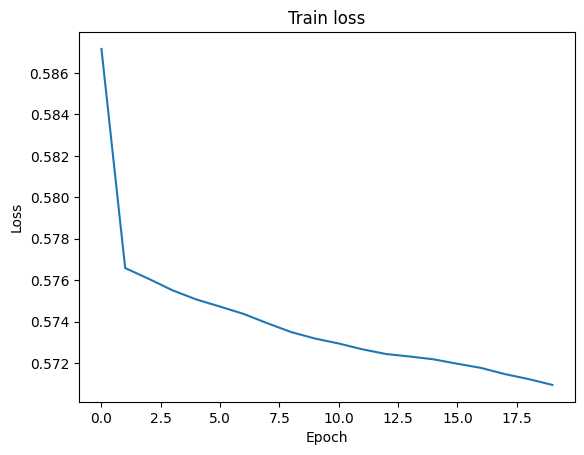

In [32]:
plt.plot(losses)
plt.title('Train loss')
plt.xlabel('Epoch')
_ = plt.ylabel('Loss')

In [33]:
attack_model.eval()

Sequential(
  (0): Linear(in_features=20, out_features=40, bias=True)
  (1): ReLU()
  (2): Linear(in_features=40, out_features=10, bias=True)
  (3): ReLU()
  (4): Linear(in_features=10, out_features=2, bias=True)
)

In [34]:
def shadow_model_attack(x, y, probs):
    X = torch.cat([
        probs.cpu(),
        nn.functional.one_hot(y, num_classes=10),
    ], dim=1)
    
    pred_probs = attack_model(X)
    return pred_probs[:, 1].cpu().detach().numpy()

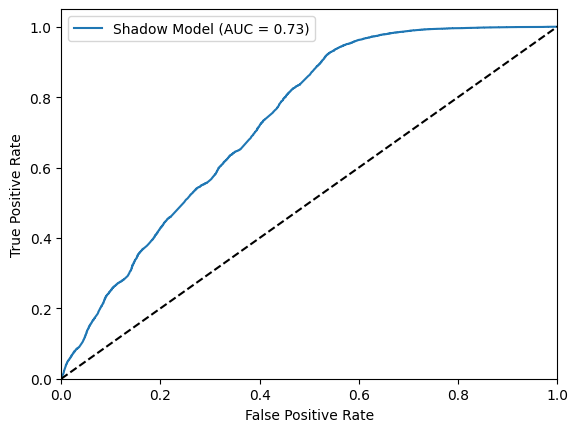

In [35]:
scores = run_attack(shadow_model_attack)
plot_roc(scores, 'Shadow Model')